In this notebook, I am going to apply transfer learning to classify Cat and Dogs in a given image.      
Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem. For instance, features from a model that has learned to identify racoons may be useful to kick-start a model meant to identify tanukis.

Transfer learning is usually done for tasks where your dataset has too little data to train a full-scale model from scratch.

The most common incarnation of transfer learning in the context of deep learning is the following workflow: 
1. Take layers from a previously trained model.
2. Freeze them, so as to avoid destroying any of the information they contain during future training rounds.
3. Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset.
4. Train the new layers on your dataset.

Here, I am using VGG16

Keras Blog Link: https://keras.io/guides/transfer_learning/

In [1]:
# Kaggle API key
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
# Downloading the datset from kaggle
!kaggle datasets download -d salader/dogs-vs-cats

100% 1.06G/1.06G [00:04<00:00, 291MB/s]
100% 1.06G/1.06G [00:04<00:00, 268MB/s]


In [3]:
# Unzipping downloaded file and save it in a particular folder
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
#Importing neccesay modules and packages
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten
from keras.applications.vgg16 import VGG16

In [5]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,  #Do not want dense layer of VGG16
    input_shape=(150,150,3)
)

58889256/58889256 [==============================] - 0s 0us/step


In [6]:
#Base summary
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [7]:
#Customize model
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [8]:
#Final model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Freazing conv_base 
conv_base.trainable = False

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [11]:
# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [12]:
# Normalize
def process(image,label):
    image = tensorflow.cast(image/255. ,tensorflow.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [13]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [14]:
history = model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
625/625 [==============================] - 74s 104ms/step - loss: 0.2663 - accuracy: 0.8891 - val_loss: 0.2383 - val_accuracy: 0.9010
Epoch 2/10
625/625 [==============================] - 65s 103ms/step - loss: 0.1869 - accuracy: 0.9212 - val_loss: 0.2223 - val_accuracy: 0.9080
Epoch 3/10
625/625 [==============================] - 65s 104ms/step - loss: 0.1633 - accuracy: 0.9319 - val_loss: 0.2279 - val_accuracy: 0.9064
Epoch 4/10
625/625 [==============================] - 65s 104ms/step - loss: 0.1430 - accuracy: 0.9409 - val_loss: 0.2325 - val_accuracy: 0.9100
Epoch 5/10
625/625 [==============================] - 65s 104ms/step - loss: 0.1159 - accuracy: 0.9538 - val_loss: 0.2282 - val_accuracy: 0.9140
Epoch 6/10
625/625 [==============================] - 65s 104ms/step - loss: 0.0952 - accuracy: 0.9623 - val_loss: 0.2483 - val_accuracy: 0.9118
Epoch 7/10
625/625 [==============================] - 65s 104ms/step - loss: 0.0744 - accuracy: 0.9705 - val_loss: 0.3015 - val_ac

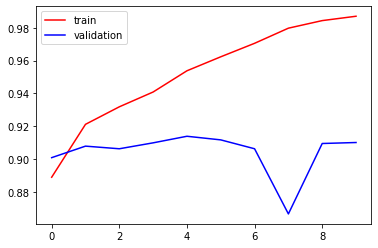

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

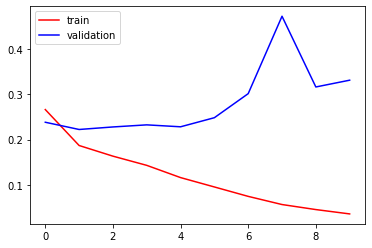

In [16]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

To increase the val_accuracy we can add Dropout layer, and few more layers like Batch Normalization technique.

In [18]:
#Customize model
model2 = Sequential()

from keras.layers import Dropout
model2.add(conv_base)
model2.add(Flatten())
model2.add(Dense(256,activation='relu'))
model2.add(Dropout(0.1))             
model2.add(Dense(1,activation='sigmoid'))

In [19]:
#Overall model summary
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [20]:
model2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [21]:
#Train the model and store the result in a variable
history2 = model2.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
625/625 [==============================] - 66s 104ms/step - loss: 0.2674 - accuracy: 0.8856 - val_loss: 0.2118 - val_accuracy: 0.9086
Epoch 2/10
625/625 [==============================] - 65s 104ms/step - loss: 0.1913 - accuracy: 0.9198 - val_loss: 0.2441 - val_accuracy: 0.8976
Epoch 3/10
625/625 [==============================] - 65s 104ms/step - loss: 0.1602 - accuracy: 0.9319 - val_loss: 0.2029 - val_accuracy: 0.9134
Epoch 4/10
625/625 [==============================] - 65s 103ms/step - loss: 0.1374 - accuracy: 0.9447 - val_loss: 0.2090 - val_accuracy: 0.9146
Epoch 5/10
625/625 [==============================] - 65s 104ms/step - loss: 0.1024 - accuracy: 0.9592 - val_loss: 0.2314 - val_accuracy: 0.9158
Epoch 6/10
625/625 [==============================] - 65s 104ms/step - loss: 0.0891 - accuracy: 0.9646 - val_loss: 0.2985 - val_accuracy: 0.8998
Epoch 7/10
625/625 [==============================] - 65s 103ms/step - loss: 0.0701 - accuracy: 0.9729 - val_loss: 0.2947 - val_ac

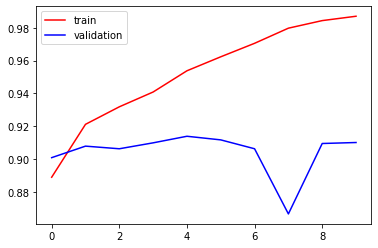

In [22]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

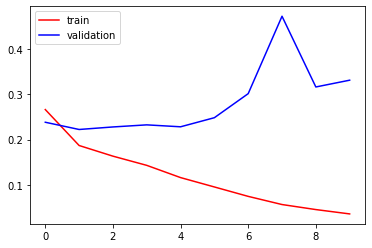

In [23]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()